In [1]:
import requests

user = "drewpager"
repo = "volutility"

ticker_path = []

url = "https://api.github.com/repos/{}/{}/git/trees/master?recursive=1".format(user, repo)
r = requests.get(url)
res = r.json()

for file in res["tree"]:
    ticker_path.append(file["path"])
    
del ticker_path[0:3]
del ticker_path[8540:]

# print(ticker_path)

In [51]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

download_root = "https://raw.githubusercontent.com/drewpager/volutility/master/"
tickers = ['Data/ETFs/aadr.us.txt','Data/ETFs/aaxj.us.txt', 'Data/ETFs/acim.us.txt']
stock_urls = []
dz = pd.DataFrame()

#replace 'tickers' with 'ticker_path' when ready
for i in ticker_path:
    stock_urls.append(download_root + i)

new_urls = stock_urls[:20]

for x in new_urls:
    dz = dz.append(pd.read_csv(x))
    df = dz

df = df.drop("OpenInt", axis=1)
df.describe()
# stock_url = download_root + stock_path + "/a.us.txt"

# df = pd.read_csv(stock_url)



# df.info()

,Open,High,Low,Close,Volume
count,40421.000000,40421.000000,40421.000000,40421.000000,4.042100e+04
mean,47.777239,48.069261,47.431139,47.761192,2.786480e+05
std,40.477118,41.126573,39.664223,40.443570,6.463150e+05
min,9.088600,9.180000,8.800000,9.165800,0.000000e+00
25%,23.033000,23.206000,22.840000,23.028000,4.964000e+03
50%,37.450000,37.666000,37.166000,37.421000,2.492600e+04
75%,56.708000,56.921000,56.423000,56.723000,2.336760e+05
max,740.680000,764.160000,708.080000,730.520000,1.345202e+07


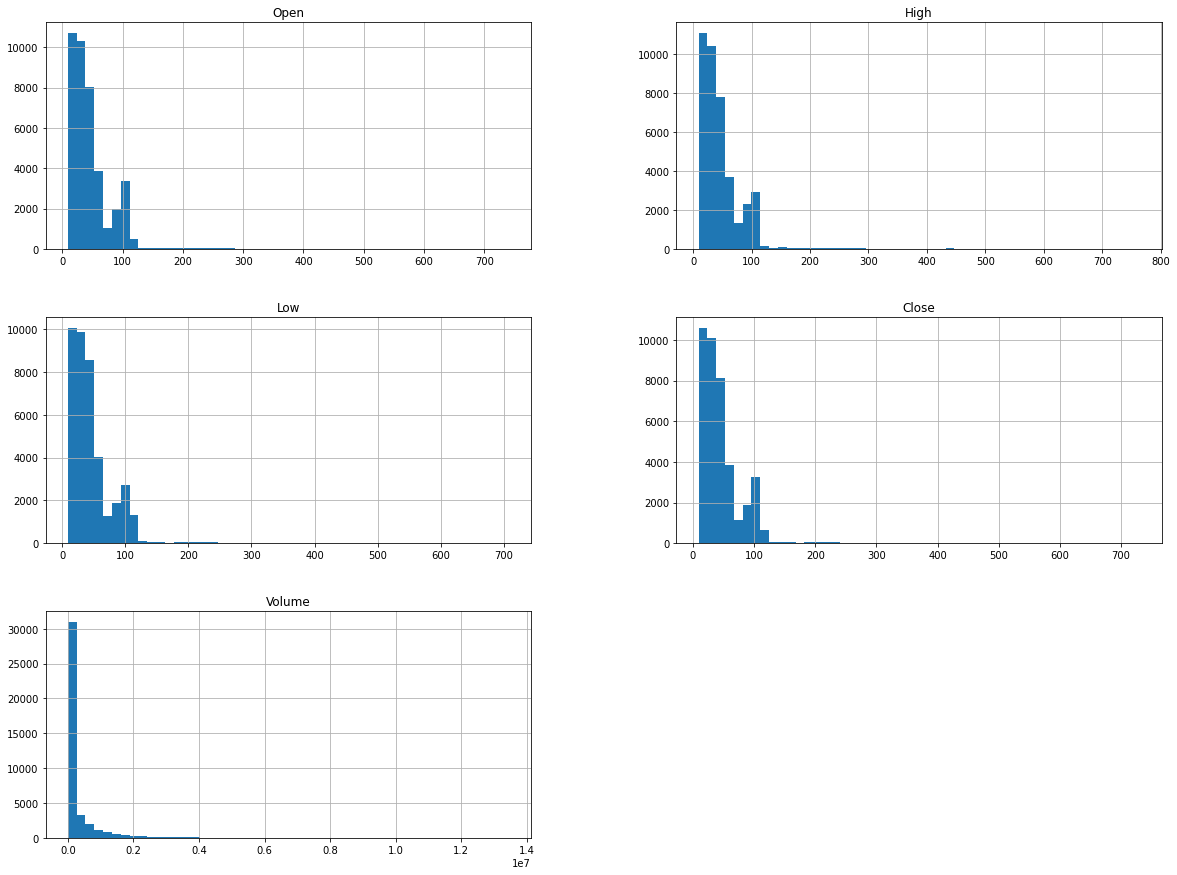

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [4]:
# import numpy as np
# def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data))
#     test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_set_size]
#     train_indices = shuffled_indices[test_set_size:]
#     return data.iloc[train_indices], data.iloc[test_indices]

# train_set, test_set = split_train_test(df, 0.2)
# print(len(test_set), 'train + ', len(train_set), 'test')

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
import hashlib
import numpy as np

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

stocks_with_id = df.reset_index()
train_set, test_set = split_train_test_by_id(stocks_with_id, 0.2, "index")

In [6]:
data = train_set.copy()
# get the row indices as a list and create a range from the 30th index (37) to the end of index.

data["Close30"] = data["Close"].shift(-30)

data = data.dropna()

# percentage change over 30 day period
data["percent_chg"] = (data["Close30"] - data["Close"])/data["Close"] * 100
# average of all price points throughout trading day multiplied by volume
data["dollar_vol"] = np.average([data["Open"], data["High"], data["Low"], data["Close"]]) * data["Volume"]
# did volume result in net positive or net negative trading
data["vol_direction"] = data["Close"] - data["Open"] * data["Volume"]

data


,index,Date,Open,High,Low,Close,Volume,Close30,percent_chg,dollar_vol,vol_direction
0,0,2010-07-21,24.333,24.3330,23.9460,23.946,43321,26.244,9.596592,2.069872e+06,-1054105.947
1,1,2010-07-22,24.644,24.6440,24.3620,24.487,18031,26.437,7.963409,8.615188e+05,-444331.477
2,2,2010-07-23,24.759,24.7590,24.3140,24.507,8897,26.486,8.075244,4.250975e+05,-220256.316
3,3,2010-07-26,24.624,24.6240,24.4490,24.595,19443,26.408,7.371417,9.289840e+05,-478739.837
6,6,2010-07-29,24.527,24.5270,24.2560,24.256,1238,26.960,11.147757,5.915148e+04,-30340.170
...,...,...,...,...,...,...,...,...,...,...,...
40378,2470,2017-09-13,61.260,61.2600,61.0909,61.100,26816,65.700,7.528642,1.281265e+06,-1642687.060
40379,2471,2017-09-14,61.180,61.2499,61.0499,61.170,23598,65.830,7.618113,1.127509e+06,-1443664.470
40380,2472,2017-09-15,61.470,61.6500,61.2600,61.650,23646,66.150,7.299270,1.129803e+06,-1453457.970
40382,2474,2017-09-19,62.190,62.2400,62.0800,62.220,17517,65.680,5.560913,8.369600e+05,-1089320.010


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


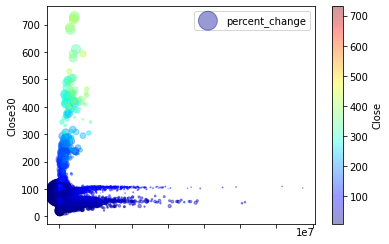

In [7]:
data.plot(kind="scatter", x="Volume", y="Close30", alpha=0.4, s=data["percent_chg"], label="percent_change", c="Close", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [8]:
corr_matrix = data.corr()
corr_matrix["Close30"]

index           -0.023801
Open             0.944107
High             0.943181
Low              0.945855
Close            0.944796
Volume           0.291413
Close30          1.000000
percent_chg      0.091356
dollar_vol       0.291413
vol_direction   -0.500296
Name: Close30, dtype: float64

array([[<AxesSubplot:xlabel='Close', ylabel='Close'>,
        <AxesSubplot:xlabel='Open', ylabel='Close'>,
        <AxesSubplot:xlabel='Close30', ylabel='Close'>,
        <AxesSubplot:xlabel='percent_chg', ylabel='Close'>,
        <AxesSubplot:xlabel='Volume', ylabel='Close'>],
       [<AxesSubplot:xlabel='Close', ylabel='Open'>,
        <AxesSubplot:xlabel='Open', ylabel='Open'>,
        <AxesSubplot:xlabel='Close30', ylabel='Open'>,
        <AxesSubplot:xlabel='percent_chg', ylabel='Open'>,
        <AxesSubplot:xlabel='Volume', ylabel='Open'>],
       [<AxesSubplot:xlabel='Close', ylabel='Close30'>,
        <AxesSubplot:xlabel='Open', ylabel='Close30'>,
        <AxesSubplot:xlabel='Close30', ylabel='Close30'>,
        <AxesSubplot:xlabel='percent_chg', ylabel='Close30'>,
        <AxesSubplot:xlabel='Volume', ylabel='Close30'>],
       [<AxesSubplot:xlabel='Close', ylabel='percent_chg'>,
        <AxesSubplot:xlabel='Open', ylabel='percent_chg'>,
        <AxesSubplot:xlabel='Close30', 

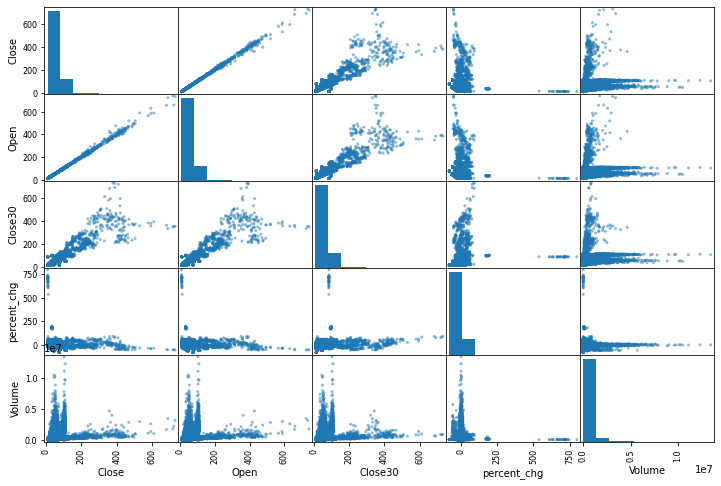

In [9]:
from pandas.plotting import scatter_matrix
attributes = ["Close", "Open", "Close30", "percent_chg", "Volume"]
scatter_matrix(data[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='Open', ylabel='Close30'>

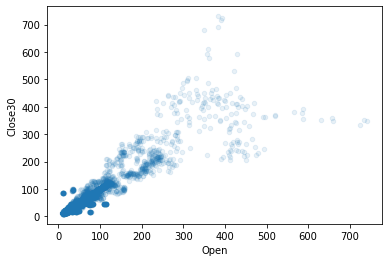

In [10]:
data.plot(kind="scatter", x="Open", y="Close30", alpha=0.1)

In [11]:
date_time = pd.to_datetime(data.pop('Date'), format='%Y-%m-%d')

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day Sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day Cosine'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year Sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year Cosine'] = np.cos(timestamp_s * (2 * np.pi / year))

In [52]:
# plt.plot(np.array(df['Day Sin'])[:25])
# plt.plot(np.array(df['Day Cosine'])[:25])
# plt.xlabel('Time [h]')
# plt.title('Time of day signal')

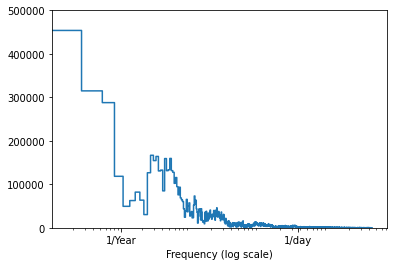

In [15]:
import tensorflow as tf

fft = tf.signal.rfft(data['Close30'])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(data['Close30'])
hours_per_year = 24 * 365.2425
years_per_dataset = n_samples/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 500000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [16]:
n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

num_features = data.shape[1]
test_data.head()

,index,Open,High,Low,Close,Volume,Close30,percent_chg,dollar_vol,vol_direction
36362,1568,110.17,110.18,109.95,109.99,17066,110.09,0.090917,8.154112e+05,-1880051.23
36363,1569,109.80,110.33,109.53,110.21,27203,109.86,-0.317576,1.299756e+06,-2986779.19
36364,1570,109.89,110.28,109.65,109.92,23476,110.08,0.145560,1.121680e+06,-2579667.72
36365,1571,109.80,110.58,109.70,109.99,148571,109.93,-0.054550,7.098703e+06,-16312985.81
36366,1572,109.81,110.40,109.62,110.07,35702,110.07,0.000000,1.705837e+06,-3920326.55


In [17]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

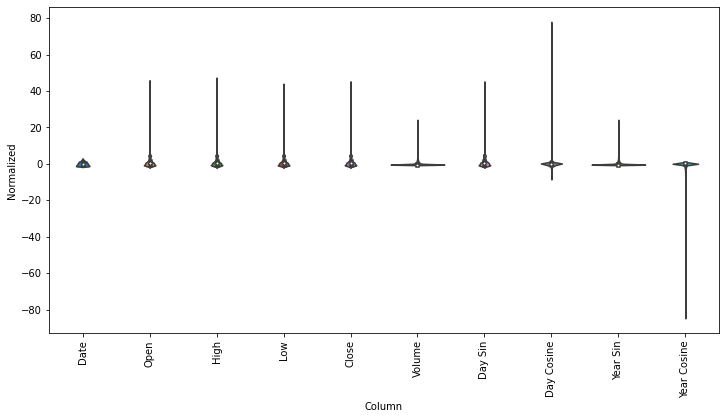

In [18]:
import seaborn as sns

df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [19]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_data=train_data, val_data=val_data, test_data=test_data, label_columns=None):
        #store the raw data 
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        
        #workout label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_data.columns)}
        
        #workout the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
        
    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    

In [66]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=30, label_columns=['Close30'])
w1

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [59]
Label column name(s): ['Close30']

In [67]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.label_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
    
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [68]:
example_window = tf.stack([np.array(train_data[:w1.total_window_size]),
                           np.array(train_data[100:100+w1.total_window_size]),
                           np.array(train_data[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All Shapes are: (batch, time, features)')
print(f'Window Shape: {example_window.shape}')
print(f'Input Shape: {example_inputs.shape}')
print(f'Label Shape: {example_labels.shape}')


All Shapes are: (batch, time, features)
Window Shape: (3, 60, 10)
Input Shape: (3, 30, 10)
Label Shape: (3, 1, 1)


In [69]:
w1.example = example_inputs, example_labels

AttributeError: can't set attribute

In [70]:
def plot(self, model=None, plot_col="Close30", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [Normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label="Inputs", marker=".", zorder=-10)
    
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        
        if label_col_index is None:
            continue
        
        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker="X", edgecolors="k", label="Predictions", c="#ff7f0e", s=64)
            
        if n == 0:
            plt.legend()
            
    plt.xlabel('Close30')

WindowGenerator.plot = plot

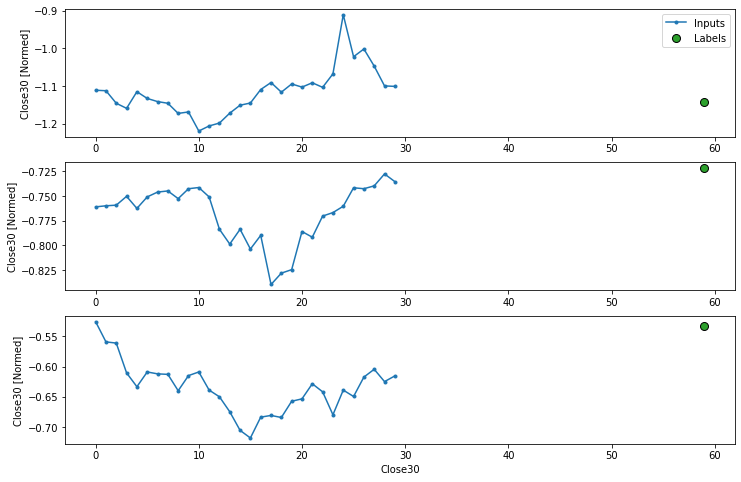

In [71]:
w1.plot()

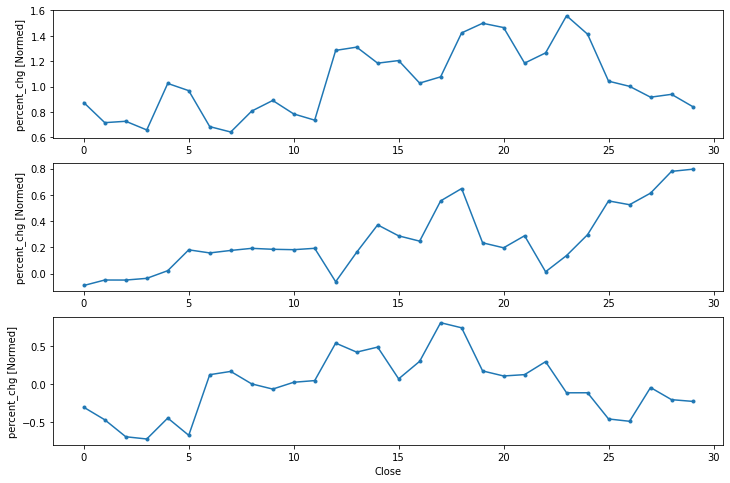

In [26]:
w1.plot(plot_col='percent_chg')

In [27]:
import tensorflow as tf

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [28]:
@property
def train(self):
    return self.make_dataset(self.train_data)

@property
def val(self):
    return self.make_dataset(self.val_data)

@property
def test(self):
    return self.make_dataset(self.test_data)

@property
def example(self):
    '''Get and cache an example to plot'''
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.train))
        
        self._example = result
        
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [29]:
w1.train.element_spec

(TensorSpec(shape=(None, 30, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [30]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 10)
Labels shape (batch, time, features): (32, 1, 1)


In [31]:
single_step = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=["Close"])
single_step

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

In [32]:
for example_inputs, example_labels in single_step.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 10)
Labels shape (batch, time, features): (32, 1, 1)


In [33]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

WindowGenerator.Baseline = Baseline

In [34]:
baseline = Baseline(label_index=4)
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step.val)
performance["Baseline"] = baseline.evaluate(single_step.test, verbose=0)

204/204 [==============================] - 1s 2ms/step - loss: 0.1160 - mean_absolute_error: 0.0853


In [35]:
wide_window = WindowGenerator(input_width=30, label_width=30, shift=1, label_columns=['Close'])
wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Close']

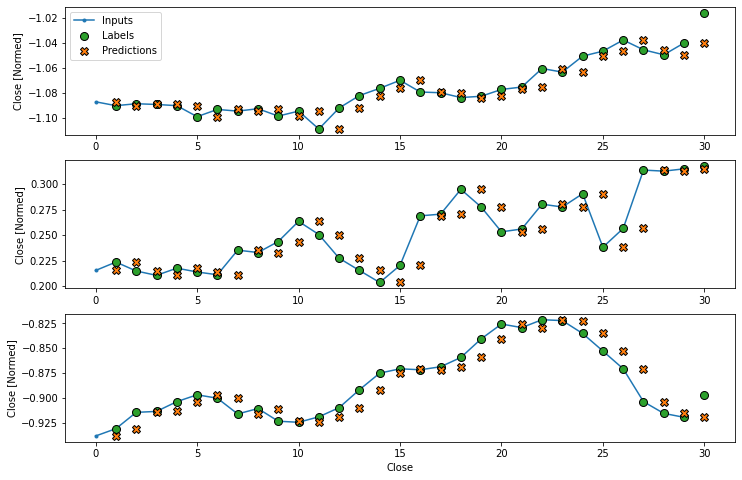

In [36]:
wide_window.plot(baseline)

In [43]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [44]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=patience,
                                                     mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    
    return history

In [39]:
# history = compile_and_fit(linear, single_step)

# val_performance['Linear'] = linear.evaluate(single_step.val)
# performance['Linear'] = linear.evaluate(single_step.test, verbose=0)

Epoch 1/20
712/712 [==============================] - 2s 3ms/step - loss: 0.1300 - mean_absolute_error: 0.2068 - val_loss: 0.5346 - val_mean_absolute_error: 0.2499
Epoch 2/20
712/712 [==============================] - 2s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0406 - val_loss: 0.2582 - val_mean_absolute_error: 0.1823
Epoch 3/20
712/712 [==============================] - 1s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0279 - val_loss: 0.2005 - val_mean_absolute_error: 0.1568
Epoch 4/20
712/712 [==============================] - 2s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0262 - val_loss: 0.1590 - val_mean_absolute_error: 0.1351
Epoch 5/20
712/712 [==============================] - 1s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0249 - val_loss: 0.1344 - val_mean_absolute_error: 0.1137
Epoch 6/20
712/712 [==============================] - 2s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0243 - val_loss: 0.1268 - val_mean_absolute_error: 0.1052
Epoch 7/20
712/7

In [46]:
import tensorflow as tf

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(dense, single_step)

val_performance['Dense'] = dense.evaluate(single_step.val)
performance['Dense'] = dense.evaluate(single_step.test, verbose=0)

Epoch 1/20
712/712 [==============================] - 2s 3ms/step - loss: 0.0101 - mean_absolute_error: 0.0443 - val_loss: 0.2712 - val_mean_absolute_error: 0.1566
Epoch 2/20
712/712 [==============================] - 1s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0316 - val_loss: 0.2287 - val_mean_absolute_error: 0.1433
Epoch 3/20
712/712 [==============================] - 2s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0310 - val_loss: 0.2243 - val_mean_absolute_error: 0.1522
Epoch 4/20
712/712 [==============================] - 2s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0296 - val_loss: 0.2034 - val_mean_absolute_error: 0.1403
Epoch 5/20
712/712 [==============================] - 2s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0294 - val_loss: 0.1912 - val_mean_absolute_error: 0.1348
Epoch 6/20
712/712 [==============================] - 2s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0290 - val_loss: 0.1777 - val_mean_absolute_error: 0.1568
Epoch 7/20
712/7

In [49]:
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close']
)

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Close']

Text(0.5, 1.0, 'Given 30 Days of Input, Predict 1 Day into the Future')

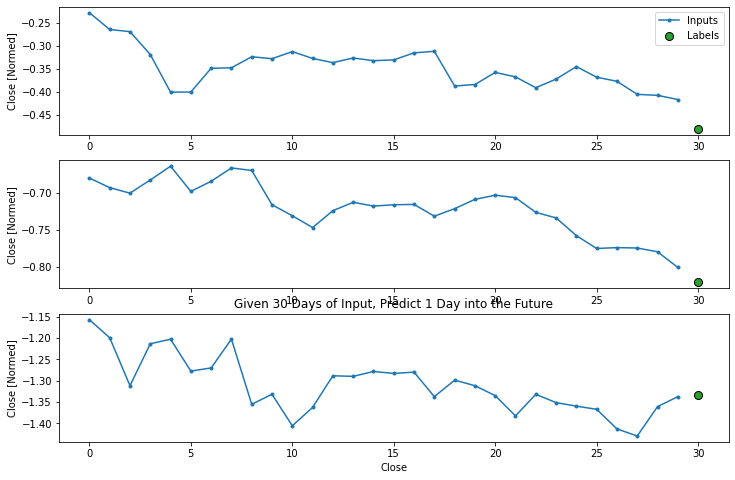

In [50]:
conv_window.plot()
plt.title('Given 30 Days of Input, Predict 1 Day into the Future')

In [73]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])

In [75]:
print('Input Shape: ', conv_window.example[0].shape)
print('Output Shape: ', multi_step_dense(conv_window.example[0]).shape)

Input Shape:  (32, 30, 10)
Output Shape:  (32, 1, 1)
